### Imports

In [161]:
import numpy  as np  
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,BatchNormalization
import keras
from keras.utils import to_categorical

# IPython display
from IPython.display import display


#### Data Pre-Processing

In [156]:
BATCH_SIZE = 64 # Reduce this to 512, 256, 128, 64, etc if your computer is too slow
IMG_SIZE = 128 # Images are 128x128
NUM_CHANNELS = 1 # Images can have multiple channels eg. rgb. These images are grayscale so we have just 1 channel
NUM_CLASSES = 10 # Digits 0-9, so we have 10 classes

IMG_SIZE_FLAT = IMG_SIZE ** 2 # 128^2 = 16384, the number of pixels per image
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
IMG_SHAPE_CHANNELS = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
INPUT_SHAPE = (-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

In [126]:
x_train_images = np.array(pd.read_pickle('train_max_x'))
x_test_images  = np.array(pd.read_pickle('test_max_x'))
y_train_labels = pd.read_csv('train_max_y.csv')
y = np.array(y_train_labels['Label'])

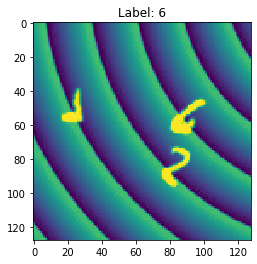

In [89]:
#Display Image from our Dataset

# Displaying the image
for id in range(1):   
    plt.title('Label: {}'.format(y_train_labels.iloc[id]['Label']))
    plt.imshow(x_train_images[id])
    plt.show()

In [114]:
print(x_train_images.shape)

(50000, 128, 128)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(x_train_images, y, random_state=42, train_size=0.8, test_size=0.2,)

In [131]:
display(X_train.shape)
display(X_test.shape)

(40000, 128, 128)

(10000, 128, 128)

In [137]:
X_train = np.reshape(X_train, INPUT_SHAPE)
X_test = np.reshape(X_test, INPUT_SHAPE)

In [142]:
def show_data(X, y_true=None, y_pred=None, n_examples=1, shape=IMG_SHAPE):
 
    for i in range(n_examples):
        image = np.array(X[i], dtype=np.float32)
        pixels = image.reshape(shape)
        plt.imshow(pixels, cmap='binary')
        plt.xlabel('Highest Value: {} Predicted Value: {}'.format(y_true[i] if y_true is not None else None, 
                                                y_pred[i] if y_pred is not None else None))
        plt.show()

In [143]:
def preprocess(x):
   
    x[x < 255] = 0 # Remove background
    x = x / 255.0 # normalize
    return x

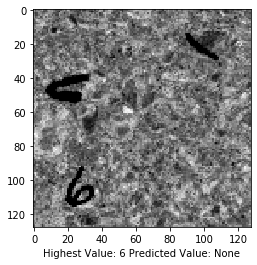

In [144]:
show_data(X_train, y_train)

In [145]:
#removes background from images 
X_train = preprocess(X_train)
X_test = preprocess(X_test)

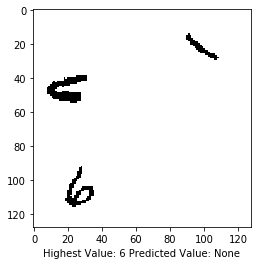

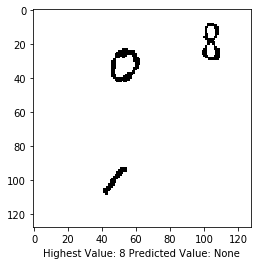

In [147]:
show_data(X_train, y_train)

show_data(X_test, y_test)

In [148]:
#categorical labels should always be one hot- this ensures this 
y_train_enc = to_categorical(y_train, NUM_CLASSES)
y_test_enc = to_categorical(y_test, NUM_CLASSES)

### Model Construction

In [153]:
def predict(model, X):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [154]:
def create_model():
    #implementation of functional model 
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE_CHANNELS))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    print(model.summary())
    return model

In [157]:
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x=X_train, y=y_train_enc, epochs=5, batch_size=BATCH_SIZE)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)      

NameError: name 'accuracy_score' is not defined

In [162]:
y_pred = predict(model, X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))

Your accuracy is: 0.9026


#### Alternative/Unfinished Preprocessing

In [117]:
# Reshaping the data for processing

#X_train = x_train_images.reshape(-1, 128, 128) # reshape 
#X_test = x_test_images.reshape(-1, 128, 128) # reshape
#Y_train = y_train_labels['Label']
#Y_train = Y_train.values.reshape(-1, 1)

In [118]:
# This function gets the bounding boxes around each digit
def bounding_box(x):
    box = []
    for i in range(x.shape[0]):
        image = x[i].copy()

        # threshold and find contours
        # ret value set to threshold of 254
        ret, thresh = cv2.threshold(image,254,255,0)
        contours, hierarchy = cv2.findContours(np.uint8(thresh), 0, 2)

        # finding minimum area rectangle covering contour
        min_area = []
        for c in contours:
            rect = cv2.minAreaRect(c)
            pos, size, orientation = rect
            area = max(size[0],size[1])**2
            # discarding boxes that cannot be possibly a digit
            if area > 49:
                min_area.append((area,[pos[0],pos[1],size[0],size[1],orientation]))
        
        # sorting the area, from largest
        min_area.sort(key=lambda x: x[0], reverse=True)
        min_area = list(list(zip(*min_area))[1])
        box.append(min_area)
    
    return box

In [119]:
# This function return coordinates of box around each digit
def coordinate(img, bounding_box, offset=0):
    _, image_threshold = cv2.threshold(img, 254, 255, 0)
    x_pos, y_pos, width, height, orientation = bounding_box
    box = cv2.boxPoints(((x_pos, y_pos), (width, height), orientation))
    box = np.int0(box)

    x_min = max(min(box[:,0]), 0)
    x_max = min(max(box[:,0]), image_threshold.shape[0])
    y_min = max(min(box[:,1]), 0)
    y_max = min(max(box[:,1]), image_threshold.shape[0])
    
    # bounding box without orientation
    digit = image_threshold[y_min:y_max, x_min:x_max].copy()
    
    # tightening up the bounding box 
    sum_x     = np.sum(digit,axis=0)
    nonzero_x = np.nonzero(sum_x)
    x_min    += np.amin(nonzero_x)
    x_max    -= (digit.shape[1] - np.amax(nonzero_x))

    sum_y     = np.sum(digit,axis=1)
    nonzero_y = np.nonzero(sum_y)
    y_min    += np.amin(nonzero_y)
    y_max    -= (digit.shape[0] - np.amax(nonzero_y))
    
    x_min = max(x_min-offset,0)
    x_max = min(x_max+offset,image_threshold.shape[0])
    y_min = max(y_min-offset,0)
    y_max = min(y_max+offset,image_threshold.shape[0])
    
    width  = x_max-x_min
    height = y_max-y_min
    
    return x_min, y_min, width, height
 

In [124]:
# Preprocessing of the training and testing images
#X_train_processed, Y_train_processed = preprocess(X_train) 
